# Introduction
This project is based on the Kaggle challenge called 'Titanic: Machine Learning from Disaster.'
It aims to use existing data regarding passengers aboard the Titanic, including their age, gender, cabin class, ticket fare, etc. to build a model that can  predict the survival of a passenger from the test set. 

The following steps have been taken to process the data and feed it to various classfication models.
1. Data Cleaning and substitutions for null values
2. Encoding categorical variables using the sklearn library
3. Reducing skewness of numerical variables using log transfrmation
4. Creating new, meaningful features that capture the relevant information better.
5. Making trial runs with various classification models and assessing accuracy using 5-fold cross validation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#Loading training and test sets
ts=pd.read_csv('train_titanic.csv')
test_set=pd.read_csv('test_titanic.csv')

In [7]:
ts.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Cleaning and processing

In [8]:
#Deleting PassengerId since it does not hold much useful information
del ts['PassengerId']

In [9]:
#Remove null values in Embarked column
ts['Embarked'].fillna(ts['Embarked'].mode()[0],inplace=True)
test_set['Embarked'].fillna(ts['Embarked'].mode()[0],inplace=True)

In [10]:
#Encoding values in Sex and Embarked columns
from sklearn.preprocessing import LabelEncoder
var_mod = ['Sex','Embarked']
le = LabelEncoder()
for i in var_mod:
    ts[i] = le.fit_transform(ts[i])
    test_set[i]=le.fit_transform(test_set[i])

In [11]:
#Replacing null values with the mean value in the Agee column
ts['Age'].fillna(ts['Age'].mean(),inplace=True)
test_set['Age'].fillna(test_set['Age'].mean(),inplace=True)

(array([732., 106.,  31.,   2.,  11.,   6.,   0.,   0.,   0.,   3.]),
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <a list of 10 Patch objects>)

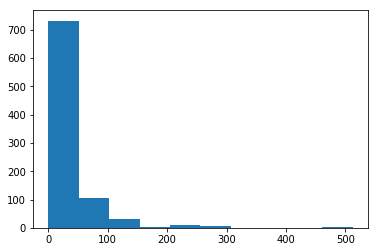

In [12]:
plt.hist(ts['Fare'])

In [13]:
# Before taking log, ensure that 0 values are converted to some other value-- here to 1.
ts['Fare'][ts['Fare']==0]=1
test_set['Fare'][test_set['Fare']==0]=1

/Users/emilbiju/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/emilbiju/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
ts['Fare_log']=np.log(ts['Fare'])
test_set['Fare_log']=np.log1p(test_set['Fare'])

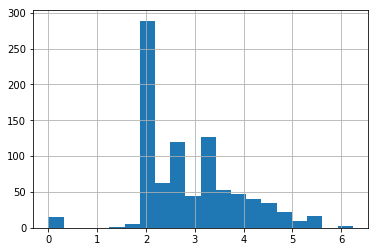

In [15]:
ts['Fare_log'].hist(bins=20)

In [24]:
print('Varaince Before taking log : '+str(ts['Fare'].var())+'         '+'Variance After taking log : '+str(ts['Fare_log'].var()))

Varaince Before taking log : 2468.3678808393965         Variance After taking log : 1.0058062683853384


# Trials with known classfication models

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
  #Fit the model:
  model.fit(data[predictors],data[outcome])
  
  #Make predictions on training set:
  predictions = model.predict(data[predictors])
  
  #Print accuracy
  accuracy = metrics.accuracy_score(predictions,data[outcome])
  print ("Accuracy : %s" % "{0:.3%}".format(accuracy))

  #Perform k-fold cross-validation with 5 folds
  kf = KFold(data.shape[0], n_folds=5)
  error = []
  for train, test in kf:
    # Filter training data
    train_predictors = (data[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = data[outcome].iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
 
  print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

  #Fit the model again so that it can be refered outside the function:
  model.fit(data[predictors],data[outcome]) 

/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [26]:
#Total number of family members is a more meaningful metric
ts['Total_family']=ts['SibSp']+ts['Parch']+1
test_set['Total_family']=test_set['SibSp']+test_set['Parch']+1

Here, we make trials with various standard machine learning models and by including various combinations of features.
The best result was obtained using XGBoost with all the categorical features encoded as onehot variables

In [27]:
model=LogisticRegression()
outcome_var='Survived'
predictors=['Fare_log','Pclass','Age','SibSp','Parch']
classification_model(model,ts,predictors,outcome_var)

Accuracy : 71.380%
Cross-Validation Score : 70.042%


In [65]:
#The Total family feature performs slightly better
model=LogisticRegression()
outcome_var='Survived'
predictors=['Fare_log','Pclass','Age','Total_family']
classification_model(model,ts,predictors,outcome_var)

Accuracy : 71.268%
Cross-Validation Score : 70.491%


In [29]:
#Decision Tree Classifier shows some overfitting
model=DecisionTreeClassifier()
outcome_var='Survived'
predictors=['Fare_log','Pclass','Age','Total_family']
classification_model(model,ts,predictors,outcome_var)

Accuracy : 95.511%
Cross-Validation Score : 63.638%


In [30]:
#Random Tree Classifier shows some overfitting
model=RandomForestClassifier()
outcome_var='Survived'
predictors=['Fare_log','Pclass','Age','Total_family']
classification_model(model,ts,predictors,outcome_var)

Accuracy : 93.266%
Cross-Validation Score : 67.453%


In [35]:
#Using the Embarked column as well makes the model perform better.
model=LogisticRegression()
outcome_var='Survived'
predictors=['Fare_log','Pclass','Age','Total_family','Embarked']
classification_model(model,ts,predictors,outcome_var)

Accuracy : 71.942%
Cross-Validation Score : 71.503%


In [66]:
#Now, we try using XGBoost for better results
import xgboost as xgb
from xgboost import XGBClassifier

In [67]:
model=XGBClassifier()
outcome_var='Survived'
predictors=['Fare_log','Pclass','Age','Total_family','Embarked']
classification_model(model,ts,predictors,outcome_var)  

/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

Accuracy : 77.104%
Cross-Validation Score : 70.376%


/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Now, we convert the Embarked column into a set of 3 columns hoding onehot values corresponding to each possible outcome

In [38]:
ts['fin0']=(ts['Embarked'] ==0)*1
ts['fin1']=(ts['Embarked'] ==1)*1
ts['fin2']=(ts['Embarked'] ==2)*1

test_set['fin0']=(test_set['Embarked'] ==0)*1
test_set['fin1']=(test_set['Embarked'] ==1)*1
test_set['fin2']=(test_set['Embarked'] ==2)*1

In [39]:
ts['cls0']=(ts['Pclass'] ==0)*1
ts['cls1']=(ts['Pclass'] ==1)*1
ts['cls2']=(ts['Pclass'] ==2)*1

test_set['cls0']=(test_set['Pclass'] ==0)*1
test_set['cls1']=(test_set['Pclass'] ==1)*1
test_set['cls2']=(test_set['Pclass'] ==2)*1

In [43]:
ts['male']=(ts['Sex']==1)*1
ts['female']=(ts['Sex']==0)*1

test_set['male']=(test_set['Sex']==1)*1
test_set['female']=(test_set['Sex']==0)*1

Now, we use the new columns and notice that we achieve considerably better results when the column for Gender is converted to onehot. We try both Logistic Regression and XGBClassifier. 

XGBClassifier has better training accuracy, but Logistic Regression generalises better.

In [45]:
model=LogisticRegression()
outcome_var='Survived'
predictors=['Pclass','Age','male','female','Total_family','Fare']
classification_model(model,ts,predictors,outcome_var)

Accuracy : 80.135%
Cross-Validation Score : 79.910%


In [42]:
model=XGBClassifier()
outcome_var='Survived'
predictors=['Pclass','Age','male','female','Total_family','Fare']
classification_model(model,ts,predictors,outcome_var)

/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

Accuracy : 87.318%
Cross-Validation Score : 83.053%


/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


We are now ready to make predictions on the test set. We generate the csv file with predicitons and name it as res.csv

In [49]:
model=XGBClassifier()
outcome='Survived'
model.fit(ts[predictors],ts[outcome])
data=test_set
predictors=['Pclass','Age','male','female','Total_family','Fare']
predictions=model.predict(data[predictors])
test_set['Survived']=predictions

/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [50]:
res=pd.DataFrame(predictions,test_set['PassengerId'])
res.rename(columns={0:'Survived'},inplace=True)

In [51]:
res.to_csv('res.csv')

One of the columns that we haven't used so far is the Cabin column. Though this may contain several null values, this may hold useful information regarding the cabin position, closeness to the deck and so on.
We replace the null values with an arbitrary cabin name 'U' and extract the first letter from each of the cabin names

In [52]:
ts['Cabin'].fillna('U',inplace=True)
test_set['Cabin'].fillna('U',inplace=True)

In [53]:
ts['Cabin1']=ts['Cabin'].astype(str).str[0]
test_set['Cabin1']=test_set['Cabin'].astype(str).str[0]

In [59]:
ts['Cabin1'].unique()

array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [60]:
#OneHot encoding of 1st character of cabin values.
arr=ts['Cabin1'].unique()
for i in arr:
    ts[i]=(ts['Cabin1']==i)*1

In [61]:
arr2=test_set['Cabin1'].unique()
for i in arr2:
    test_set[i]=(test_set['Cabin1']==i)*1

In [62]:
model=XGBClassifier()
outcome_var='Survived'
predictors=['cls1','cls2','cls0','Age','male','female','Total_family','Fare','U', 'C', 'E', 'G', 'D', 'A', 'B', 'F']
classification_model(model,ts,predictors,outcome_var)

/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy : 86.644%


/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Cross-Validation Score : 82.829%


In [63]:
model=XGBClassifier()
outcome='Survived'
model.fit(ts[predictors],ts[outcome])
data=test_set
predictors=['cls1','cls2','cls0','Age','male','female','Total_family','Fare','U', 'C', 'E', 'G', 'D', 'A', 'B', 'F']
predictions=model.predict(data[predictors])
test_set['Survived']=predictions

/Users/emilbiju/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [64]:
res=pd.DataFrame(predictions,test_set['PassengerId'])
res.rename(columns={0:'Survived'},inplace=True)
res.to_csv('res2.csv')

# Summary
Note that this does not have a very high cross validation accuracy
The earlier method using Logistic Regression seems to generalise better.
These methods appear to give an accuracy upto 77.99%. Since there could be a lot of other issues that could have impacted survival, many of which may have been arbitrary and not very evident from the given data, it is quite challenging to make more accurate predictions with these models.